# Load everything we will need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback, EarlyStopping
from time import time

Using TensorFlow backend.


# Load our 224 x 224 data: Images(x) and labels(y)

In [2]:
# Load npz file containing image arrays
x_npz = np.load("x_Pneumothorax_balanced_224.npz")
x = x_npz['arr_0']
# Load binary encoded labels for Lung Infiltrations: 0=disiese not found 1=disiese found
y_npz = np.load("y_Pneumothorax_balanced_224.npz")
y = y_npz['arr_0']

# Check the number of deseas found in the dataset!!

In [3]:
#0: not found, 1: found
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))


{0: 4556, 1: 5302}


# If you want to create a mask to balance the samples for the two classes uncomment the lines below:

In [4]:
#n = 4556
#mask = np.hstack([np.random.choice(np.where(y == l)[0], n, replace=False) for l in np.unique(y)])

In [5]:
#x = x[mask]
#y = y[mask]

In [6]:
#unique, counts = np.unique(y, return_counts=True)
#print(dict(zip(unique, counts)))

# Or if you want to use a weight class just run the code

In [7]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y),y)
print(class_weights)

[ 1.08187006  0.92964919]


In [8]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_valtest, y_train, y_valtest = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

# Second split the 20% into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)

In [9]:
#Is better to use the weights of the train samples

class_weights_train = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)
print(class_weights_train)

[ 1.08175583  0.92973355]


In [10]:
# I'm using the categorical cross entropy as loss function,
#so we need to convert our labels streming into a category list
nb_categories = 2

from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,nb_categories)
y_test = np_utils.to_categorical(y_test,nb_categories)
y_valtest = np_utils.to_categorical(y_valtest,nb_categories)
y_val = np_utils.to_categorical(y_val,nb_categories)

# Check the dimensions of the images:

In [11]:
print(np.array(X_train).shape)
print(np.array(X_val).shape)
print(np.array(X_test).shape)

(7886, 224, 224, 3)
(986, 224, 224, 3)
(986, 224, 224, 3)


# Start to build our model.

In [12]:
#I'm going to use data augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras import backend as K


In [13]:
# define my input parameters.

img_width, img_height = X_train.shape[1], X_train.shape[2]
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
epochs = 10
batch_size = 16
Number_of_conv_layers = 5

In [14]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3),name="entrada"))
model.add(layers.BatchNormalization(name="batch_norm_0"))
model.add(layers.Activation("relu",name="activation_0"))

model.add(layers.MaxPooling2D((2, 2),name="max_pooling_0"))

model.add(layers.Conv2D(64, (3, 3),name="conv2D_1"))
model.add(layers.BatchNormalization(name="batch_norm_1"))
model.add(layers.Activation("relu",name="activation_1"))

'''
#I'm comment these layers to compare the ROC between size images and number of layers (Veronica's request!!)
model.add(layers.MaxPooling2D((2, 2),name="max_pooling_N1"))

######################################################
model.add(layers.Conv2D(64, (3, 3),name="conv2D_N1"))
model.add(layers.BatchNormalization(name="batch_norm_N1"))
model.add(layers.Activation("relu",name="activation_N1"))
###########################################################
model.add(layers.MaxPooling2D((2, 2),name="max_pooling_N2"))
######################################################
model.add(layers.Conv2D(64, (3, 3),name="conv2D_N2"))
model.add(layers.BatchNormalization(name="batch_norm_N2"))
model.add(layers.Activation("relu",name="activation_N2"))
###########################################################
'''
model.add(layers.MaxPooling2D((2, 2),name="max_pooling_1"))

model.add(layers.Conv2D(128, (3, 3),name="conv2D_2"))
model.add(layers.BatchNormalization(name="batch_norm_2"))
model.add(layers.Activation("relu",name="activation_2"))


model.add(layers.MaxPooling2D((2, 2),name="max_pooling_2"))

model.add(layers.Flatten(name="achata"))
model.add(layers.Dropout(0.2,name="dropout_0"))
model.add(layers.Dense(64,name="dense_0"))
model.add(layers.BatchNormalization(name="batch_norm_3"))
model.add(layers.Activation("relu",name="activation_3"))

model.add(layers.Dense(2,name="classificator"))
model.add(layers.BatchNormalization(name="batch_norm_4"))
model.add(layers.Activation("sigmoid",name="activation_4"))
#sparse_categorical_crossentropy
#binary_crossentropy
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
    metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
entrada (Conv2D)             (None, 222, 222, 32)      896       
_________________________________________________________________
batch_norm_0 (BatchNormaliza (None, 222, 222, 32)      128       
_________________________________________________________________
activation_0 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling_0 (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 109, 109, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 64)      0         
__________

# Export our model into json to be used latter in the layers visualization.

In [21]:
model_json = model.to_json()
with open("layers_{}_img_{}_class_{}.json".format(len(model.layers),X_train.shape[1],y_train.shape[1]), "w") as json_file:
    json_file.write(model_json)

In [22]:
# normalize our training images, flip horizontally and rotate 30 degrees

train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True, rotation_range=30)
valtest_datagen = ImageDataGenerator(rescale=1. / 255)

In [23]:
#The default behavior of flow_from_directory is to shuffle the data; 
#this means that the predictions from predict generator will not correspond to the ground truth labels 
#which you get from test_generator.classes. So set shuffle = False

train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size,shuffle=False)
validation_generator = valtest_datagen.flow(np.array(X_val), y_val, batch_size=batch_size, shuffle=False)
test_generator = valtest_datagen.flow(np.array(X_test), y_test, batch_size=batch_size,shuffle=False)

# Define my callbacks:

In [24]:
tensorboard = TensorBoard(log_dir="logs_{}_layers_{}_imgDim/{}".format(len(model.layers),X_train.shape[1],time()),histogram_freq=0,write_images=True, write_grads=True)

In [25]:
checkpointer = ModelCheckpoint(filepath='./weights_balanced_{}_layers_{}_imgDim.hdf5'.format(len(model.layers),X_train.shape[1]), verbose=1, save_best_only=True)

In [26]:
earlierstop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Run my model:

In [27]:

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    class_weight=class_weights_train,
    callbacks=[tensorboard,checkpointer,earlierstop],
)



Epoch 1/10
492/492 [==============================] - 1885s 4s/step - loss: 0.6581 - acc: 0.6177 - val_loss: 1.3169 - val_acc: 0.5369

Epoch 00001: val_loss improved from inf to 1.31690, saving model to ./weights_balanced_20_layers_224_imgDim.hdf5
Epoch 2/10
492/492 [==============================] - 1870s 4s/step - loss: 0.6291 - acc: 0.6510 - val_loss: 0.7281 - val_acc: 0.6144

Epoch 00002: val_loss improved from 1.31690 to 0.72815, saving model to ./weights_balanced_20_layers_224_imgDim.hdf5
Epoch 3/10
492/492 [==============================] - 1862s 4s/step - loss: 0.6102 - acc: 0.6695 - val_loss: 1.1548 - val_acc: 0.5464

Epoch 00003: val_loss did not improve
Epoch 4/10
492/492 [==============================] - 1833s 4s/step - loss: 0.5936 - acc: 0.6850 - val_loss: 0.7167 - val_acc: 0.5247

Epoch 00004: val_loss improved from 0.72815 to 0.71669, saving model to ./weights_balanced_20_layers_224_imgDim.hdf5
Epoch 5/10
492/492 [==============================] - 1849s 4s/step - loss:

['acc', 'loss', 'val_acc', 'val_loss']


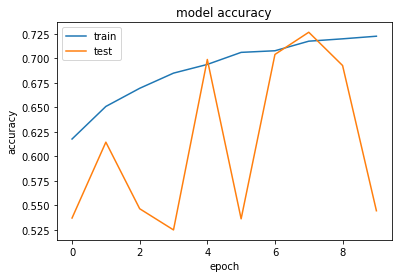

In [28]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig("/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/model_accuracy.pdf")
plt.show()

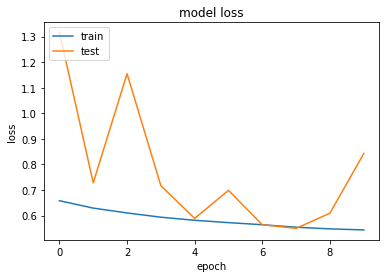

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig("/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/model_loss.pdf")
plt.show()


In [30]:
#If you want to check the best results, just uncomment below and select the best weights.

model.load_weights('weights_balanced_20_layers_224_imgDim.hdf5')

In [31]:
#Build my confusion matrix plot function
import sklearn
import itertools
from sklearn.metrics import confusion_matrix
dict_characters = { 1: 'Pneumothorax Observed', 0: 'No Pneumothorax Observed'}#['Infiltration Observed', 'No Infiltration Observed']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',fontsize=20,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=17)
    plt.yticks(tick_marks, classes,fontsize=17)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black", fontsize=20)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

In [32]:
# get the predictions from our model.

a=X_train
b=y_train
c=X_valtest
d=y_valtest
Y_pred = model.predict_generator(validation_generator,nb_validation_samples // batch_size+1)
Y_pred_classes = np.argmax(Y_pred,axis=1) 

In [35]:
#Generate a classification report for our predictions:

from sklearn.metrics import classification_report

print(classification_report(np.argmax(validation_generator.y,axis=1), Y_pred_classes, target_names=list(dict_characters.values())))


                          precision    recall  f1-score   support

No Pneumothorax Observed       0.73      0.66      0.69       455
   Pneumothorax Observed       0.73      0.79      0.76       531

             avg / total       0.73      0.73      0.73       986



# Ploting our confusion Matrices:

In [36]:
#compute the confusion matrix:
cnf_matrix = confusion_matrix(np.argmax(validation_generator.y, axis=1), Y_pred_classes)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[301 154]
 [113 418]]


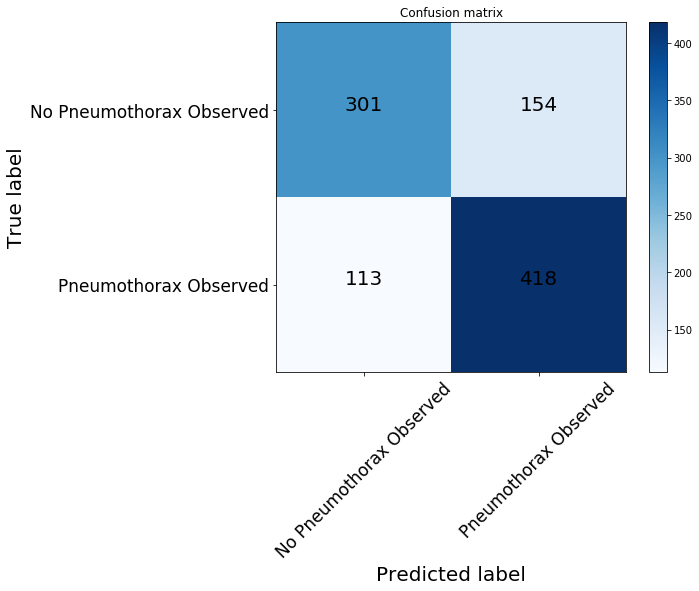

In [37]:
# Plot non-normalized confusion matrix
plt.figure(figsize=[10,8])
plot_confusion_matrix(cnf_matrix, classes=list(dict_characters.values()),
                      title='Confusion matrix')
#plt.savefig("/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/confusion_matrix_Infiltration.pdf")
plt.show()

Normalized confusion matrix
[[ 0.66  0.34]
 [ 0.21  0.79]]


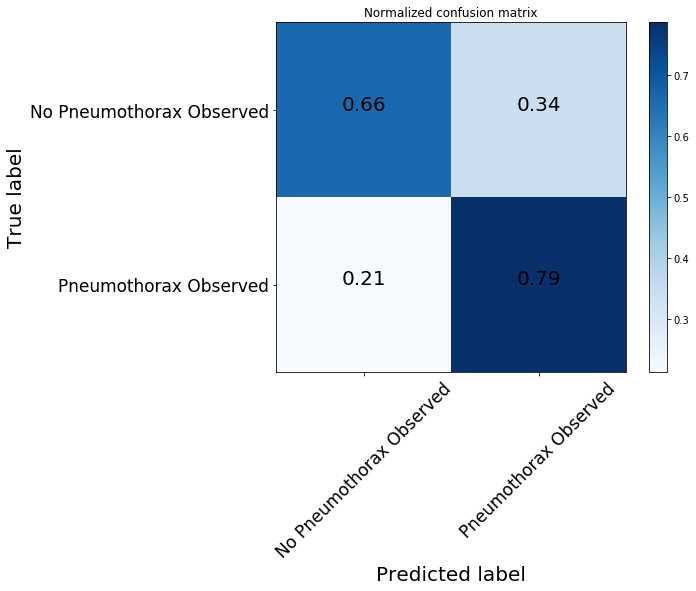

In [38]:
# Plot normalized confusion matrix
plt.figure(figsize=[10,8])
plot_confusion_matrix(cnf_matrix, classes=dict_characters.values(), normalize=True,
                      title='Normalized confusion matrix')

#plt.savefig("figs/norm_CM_balanced_2xtra.pdf")
plt.show()

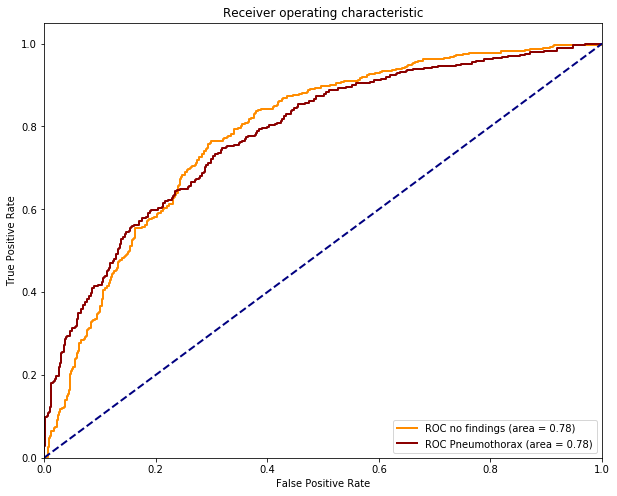

In [39]:
# Plot ROC curves for each class
from sklearn.metrics import roc_curve, auc

fpr0, tpr0, thresholds0 = roc_curve(validation_generator.y[:,0], Y_pred[:,0])
fpr1, tpr1, thresholds1 = roc_curve(validation_generator.y[:,1], Y_pred[:,1])
roc_auc0 = auc(fpr0, tpr0)
roc_auc1 = auc(fpr1, tpr1)

plt.figure(figsize=[10,8])
lw = 2
plt.plot(fpr0, tpr0, color='darkorange',
         lw=lw, label='ROC no findings (area = %0.2f)'%(roc_auc0))
plt.plot(fpr1, tpr1, color='darkred',
         lw=lw, label='ROC Pneumothorax (area = %0.2f)'%(roc_auc1))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('figs/ROC_2extra.pdf')
plt.show()

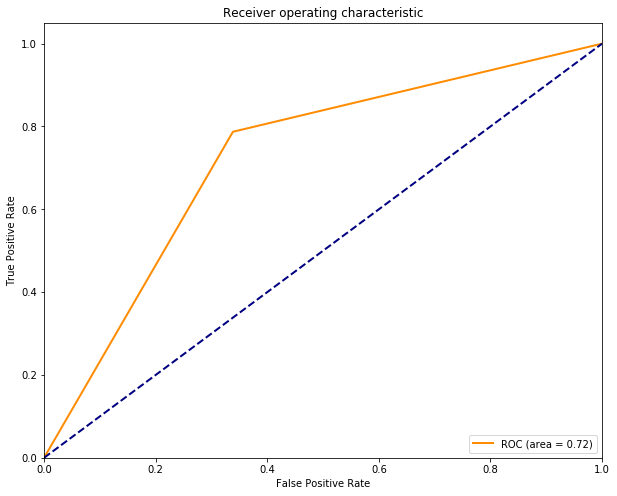

In [40]:
# Plot avarage ROC curves
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(np.argmax(validation_generator.y,axis=1), Y_pred_classes)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[10,8])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
#plt.savefig('/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/ROC_unweighted_avg.pdf')
plt.legend(loc="lower right")
plt.show()

# To plot the Precision and Recall curves:

In [45]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score


In [46]:
precision0, recall0, thresholds0 = precision_recall_curve(validation_generator.y[:,0], Y_pred[:,0])
precision1, recall1, thresholds1 = precision_recall_curve(validation_generator.y[:,1], Y_pred[:,1])

In [47]:
from sklearn.metrics import average_precision_score
average_precision0 = average_precision_score(validation_generator.y[:,0], Y_pred[:,0])
average_precision1 = average_precision_score(validation_generator.y[:,1], Y_pred[:,1])

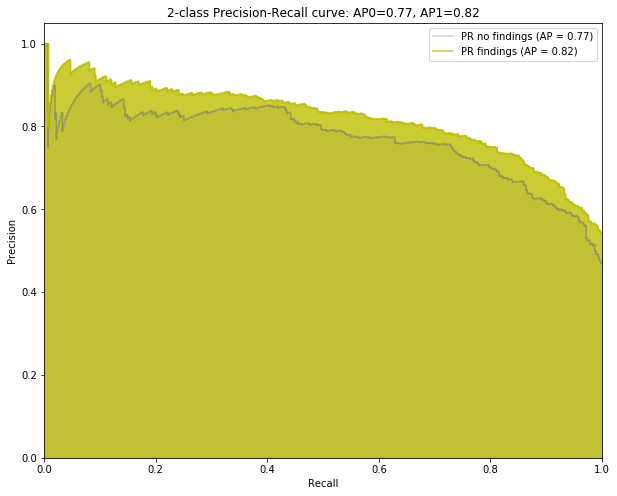

In [48]:
# Plot PR curves for each class
plt.figure(figsize=[10,8])
plt.step(recall0, precision0, color='b', alpha=0.2,
         where='post',label='PR no findings (AP = %0.2f)'%(average_precision0))
plt.fill_between(recall0, precision0, step='post', alpha=0.2,
                 color='b')
plt.step(recall1, precision1, color='y', alpha=0.8,
         where='post',label='PR findings (AP = %0.2f)'%(average_precision1))
plt.fill_between(recall1, precision1, step='post', alpha=0.8,
                 color='y')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP0={0:0.2f}, AP1={1:0.2f}'.format(
          average_precision0,average_precision1))
plt.legend(loc="best")
#plt.savefig('/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/PR_unweighted.pdf')
plt.show()

In [49]:
precision, recall, thresholds = precision_recall_curve(np.argmax(validation_generator.y, axis=1), Y_pred_classes)
average_precision = average_precision_score(np.argmax(validation_generator.y, axis=1), Y_pred_classes)

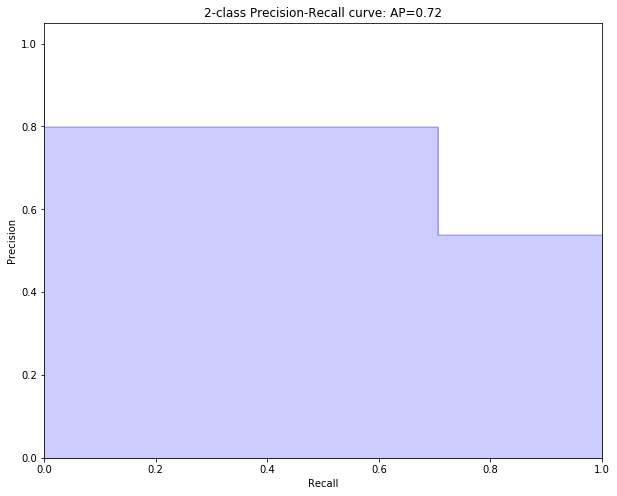

In [50]:
# Plot avarage PR curves
plt.figure(figsize=[10,8])
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
#plt.savefig('/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/PR_unweighted_avg.pdf')
plt.show()